In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")

sys.path.append('/home/ubuntu2/store_sales_time_series_forecasting_kaggle/src')

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn.ensemble import IsolationForest

from sales_project.utils import iqr_filter, iqr_clipper, reduce_size, compare_disributions
from sales_project.plotters import linear_plot, hist_box_plot, train_submission_countplot

pd.set_option('display.max_rows', 100)

sns.set_theme(context='talk', style="darkgrid", palette='dark', font='sans-serif')
tqdm.pandas()

In [3]:
message = lambda len_old, len_new: print(f"Removed {len_old - len_new} outliers, ratio - {round(100 * (len_old - len_new) / len_old, 2)}%")

# I. Reading data

In [4]:
data = {}
for file in os.listdir('../data/raw'):
    if file.endswith('.csv'):
        data[file.replace('.csv', '')] = pd.read_csv(f'../data/raw/{file}')

In [5]:
df = pd.concat([data['train'], data['test']], ignore_index=True)
df['is_submission'] = df['sales'].isnull()

In [6]:
df['date'] = pd.to_datetime(df['date'])
data['transactions']['date'] = pd.to_datetime(data['transactions']['date'])
data['oil']['date'] = pd.to_datetime(data['oil']['date'])

Reducing the memory consumption by data types

In [7]:
reduce_size(df)

  0%|          | 0/7 [00:00<?, ?it/s]

# II. Duplicates

First off, check duplicated along id column

In [8]:
print('Number of duplicates along id: ', df.duplicated(subset='id', keep=False).sum()) 

Number of duplicates along id:  0


There are no duplicates.  
Let's check other columns

In [9]:
cols = list(df.columns)
cols.remove('id')
print('Number of duplicates along other columns: ', df.duplicated(subset=cols, keep=False).sum()) 

Number of duplicates along other columns:  0


In [10]:
cols = ['date', 'store_nbr', 'family']
print('Number of duplicates along other columns: ', df.duplicated(subset=cols, keep=False).sum()) 

Number of duplicates along other columns:  0


Still no duplicates

# III. Missing time series data

The `sales` value is calculated for each `store_nbr`, `family` within `date` range.  
Let's check if all combinations are presented

In [11]:
print('Unique values for submission subset')
print(df.query(f"is_submission")[['store_nbr', 'family', 'date']].nunique())
n_dates = (df.query(f" is_submission").date.max() - df.query(f" is_submission").date.min()).days + 1
n_missing = np.prod(df.query(f" is_submission")[['store_nbr', 'family']].nunique().values) * n_dates - len(df.query(f" is_submission"))
print("Dates range in days", n_dates)
print("Missing combinations", n_missing)
print()
print('Unique values for train subset')
print(df.query(f"not is_submission")[['store_nbr', 'family', 'date']].nunique())
n_dates = (df.query(f"not is_submission").date.max() - df.query(f"not is_submission").date.min()).days + 1
n_missing = np.prod(df.query(f"not is_submission")[['store_nbr', 'family']].nunique().values) * n_dates - len(df.query(f"not is_submission"))
print("Dates range in days", n_dates)
print("Missing combinations", n_missing)
print()

Unique values for submission subset
store_nbr    54
family       33
date         16
dtype: int64
Dates range in days 16
Missing combinations 0

Unique values for train subset
store_nbr      54
family         33
date         1684
dtype: int64
Dates range in days 1688
Missing combinations 7128



In [12]:
date_set = set(pd.date_range(start=df.query(f"not is_submission").date.min(), end=df.query(f"not is_submission").date.max()))
date_set2 = set(df.query(f"not is_submission").date.unique())
date_set - date_set2

{Timestamp('2013-12-25 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2015-12-25 00:00:00'),
 Timestamp('2016-12-25 00:00:00')}

It can be seen that the same unique stored `store_nbr` and products `family` are considered for submission and train data.  
On the other hand, 4 dates are missing in the train subset. Particularly, the date is the same except for a year -  
the 25-th of December is a Christmas day.  
Let's add the corresponding missing rows   

In [13]:
dates = date_set - date_set2
stores = list(df['store_nbr'].unique())
families = list(df['family'].unique())

df2 = pd.DataFrame(list(itertools.product(dates, stores, families)), columns=['date','store_nbr', 'family'])
df2['is_submission'] = False
df2['id'] = np.arange(df['id'].max()+1, df['id'].max() + df2.shape[0] + 1)

df = pd.concat([df, df2], ignore_index=True).sort_values(by=['date', 'store_nbr', 'family']).reset_index(drop=True)

Let's fill in missing values with a lag value

In [15]:
df.loc[~df['is_submission'], 'sales'] = df.query('not is_submission')['sales'].transform(lambda x: x.fillna(method='ffill'))

Finally, let's merge the rest of the data to the main dataframe

In [16]:
df = df.merge(data['transactions'], on=['date', 'store_nbr'], how='left')
df = df.merge(data['stores'], on=['store_nbr'], how='left')
df = df.merge(data['oil'], on=['date'], how='left')

In [17]:
reduce_size(df)

  0%|          | 0/13 [00:00<?, ?it/s]

# IV. Missing data

In [18]:
for col in df.columns:
    n_null = df[col].isnull().sum()
    if n_null > 0:
        print(f"{col}:")
        print(f"{n_null} NaNs, ratio - {round(n_null/len(df)*100, 2)}%")

sales:
28512 NaNs, ratio - 0.94%
onpromotion:
7128 NaNs, ratio - 0.23%
transactions:
281424 NaNs, ratio - 9.27%
dcoilwtico:
942678 NaNs, ratio - 31.04%


In [19]:
data['test'].shape

(28512, 5)

There are missing data in `sales` column, but this is a submission part of the dataset, so it is ok  
However, there are quite a lof of NaNs in `transactions` and `dcoilwtico` columns

### dcoilwtico

Let's start with `dcoilwtico`.  
Originally, this column was a part of a dataframe, where for each date a corresponding `dcoilwtico` value  
was stated. It seems, that there are dates with no data for `dcoilwtico`

Let's consider only unique pairs [`date`, `dcoilwtico`]

In [20]:
df2 = df[['date', 'dcoilwtico']].drop_duplicates().sort_values(by='date')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1704 entries, 0 to 3034746
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1704 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 33.3 KB


In [21]:
df2

,date,dcoilwtico
0,2013-01-01,NaN
1782,2013-01-02,93.139999
3564,2013-01-03,92.970001
5346,2013-01-04,93.120003
7128,2013-01-05,NaN
...,...,...
3027618,2017-08-27,NaN
3029400,2017-08-28,46.400002
3031182,2017-08-29,46.459999
3032964,2017-08-30,45.959999


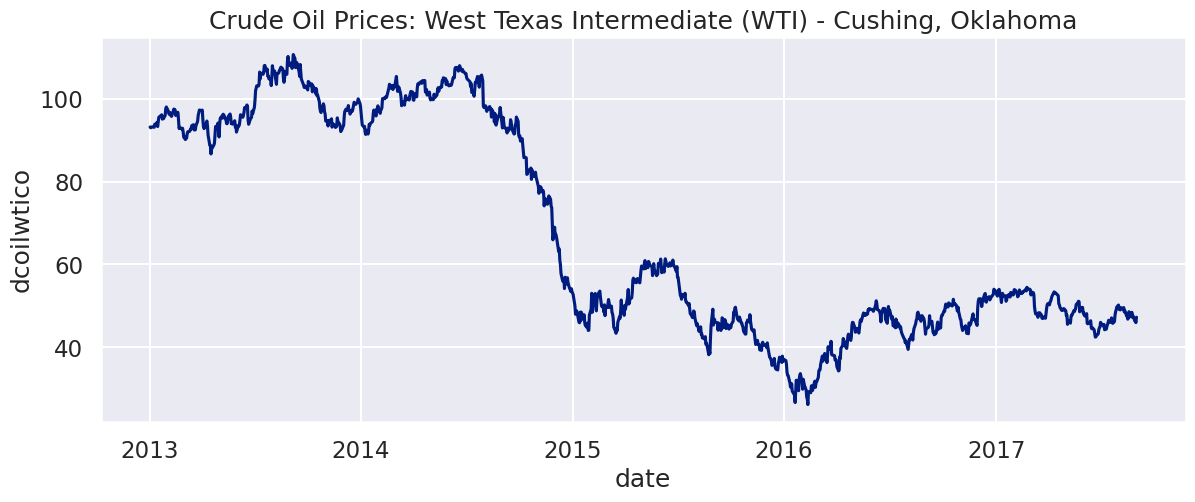

In [22]:
linear_plot(
    data=df2,
    x='date',
    y='dcoilwtico',
    title='Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma',
)

It can be seen from the time series above, that there are no major spikes. Therefore, it is possible to apply   
an interpolation method to deal with missing data. Let's consider an interpolation via a CubicSpline

In [23]:
cs = CubicSpline(
    df2.dropna()["date"],
    df2.dropna()["dcoilwtico"],
)
df2.loc[df2["dcoilwtico"].isnull(), "dcoilwtico"] = cs(
    df2[df2["dcoilwtico"].isnull()]["date"]
)


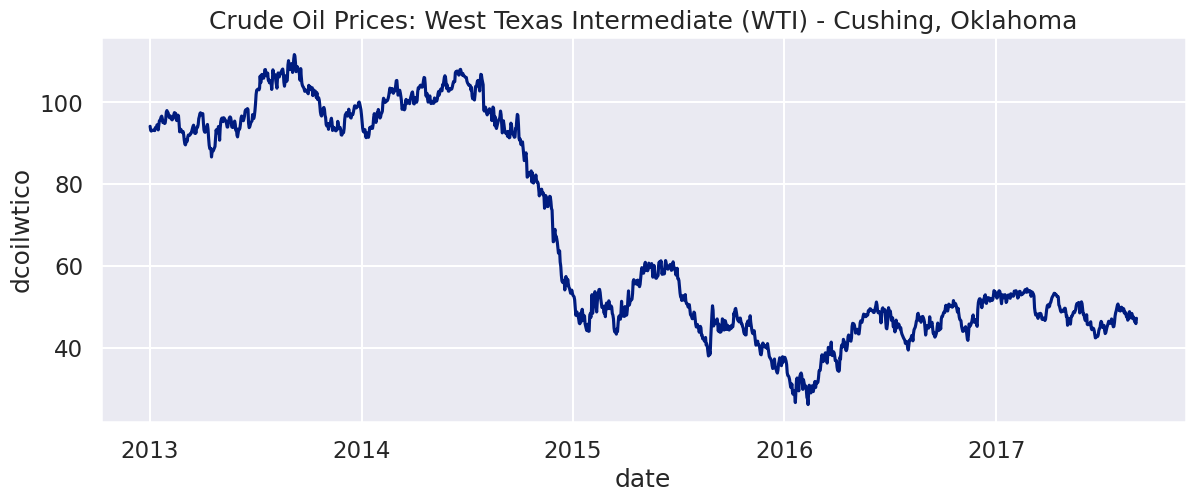

In [24]:
linear_plot(
    data=df2,
    x='date',
    y='dcoilwtico',
    title='Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma',
)

Let's apply changes to the main dataframe

In [25]:
df = (
    df
    .drop(columns=['dcoilwtico'])
    .merge(df2, on='date', how='left')
)
df['dcoilwtico'].isnull().sum()

0

### transactions

Originally, this column was a part of a dataframe, where for each `date` and `store_nbr` a corresponding `transactions` value  
was stated.

Let's consider only unique pairs [`date`, `store_nbr`, `transactions`]

In [26]:
df2 = df[['date', 'store_nbr', 'transactions']].drop_duplicates().sort_values(by=['date', 'store_nbr'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92016 entries, 0 to 3036495
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          92016 non-null  datetime64[ns]
 1   store_nbr     92016 non-null  uint8         
 2   transactions  83488 non-null  float32       
dtypes: datetime64[ns](1), float32(1), uint8(1)
memory usage: 1.8 MB


In [27]:
df2['transactions'].isnull().sum()

8528

In [27]:
# for store_nbr in df2['store_nbr'].unique():
#     linear_plot(
#         data=df2.query(f'store_nbr == {store_nbr}'),
#         x='date',
#         y='transactions',
#         title=f'Transactions in store {store_nbr}',
#         figsize=(15, 2)
#     )

From the time series above it is clear, that for there are major spikes in the distribution for each store.  
Typically, they are located during the New Year holidays.  
On the other hand, it is possible to distinguish a clear trend and seasonality patterns in most cases.  
Therefore let's apply a time-based imputation by calculating a mean value over `store_nbr`, `month`, `week`

In [28]:
df2['year'] = df2.date.dt.year
df2['month'] = df2.date.dt.month
df2['week'] = df2.date.dt.isocalendar().week

df2['transactions'] = df2.groupby(['store_nbr', 'month', 'week'])['transactions'].transform(lambda x: x.fillna(x.mean()))

In [29]:
df2['transactions'].isnull().sum()

1271

There are still some missing data left. Let's use a `month`, `weekday` aggregation

In [30]:
df2['transactions'] = df2.groupby(['month', 'week'])['transactions'].transform(lambda x: x.fillna(x.mean()))
df2['transactions'].isnull().sum()

0

Let's apply changes to the main dataframe

In [31]:
df = (
    df
    .drop(columns=['transactions'])
    .merge(df2[['date', 'store_nbr', 'transactions']], on=['date', 'store_nbr'], how='left')
)
df['transactions'].isnull().sum()

0

## onpromotion

In [32]:
df['onpromotion'].isnull().sum()

7128

The missing data for this feature was brought by adding 4 missing dates to the main dataset.  
Let's fill in missing values with the a lag value

In [33]:
df['onpromotion'] = df['onpromotion'].transform(lambda x: x.fillna(method='ffill'))

In [34]:
df['onpromotion'].isnull().sum()

0

# V. Outliers



Let's separate features into the following groups:

    numerical features
    binary categorical features
    non-binary categorical features
    datetime features

In [35]:
df.dtypes

id                       uint32
date             datetime64[ns]
store_nbr                 uint8
family                   object
sales                   float32
onpromotion             float32
is_submission              bool
city                     object
state                    object
type                     object
cluster                   uint8
dcoilwtico              float64
transactions            float32
dtype: object

In [36]:
df.nunique()

id               3036528
date                1704
store_nbr             54
family                33
sales             379610
onpromotion          367
is_submission          2
city                  22
state                 16
type                   5
cluster               17
dcoilwtico          1527
transactions        5741
dtype: int64

There are no binary features

In [35]:
date_col = 'date'
num_cols = ['sales', 'onpromotion', 'dcoilwtico', 'transactions']
cat_cols = ['family', 'city', 'state', 'type', 'cluster']

## A. Numerical columns

In [38]:
iqr_feats = {}
queries = []

### 1. sales

In [39]:
df['sales'].describe()

count    3.008016e+06
mean     3.569290e+02
std      1.091664e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.950000e+02
max      1.247170e+05
Name: sales, dtype: float64

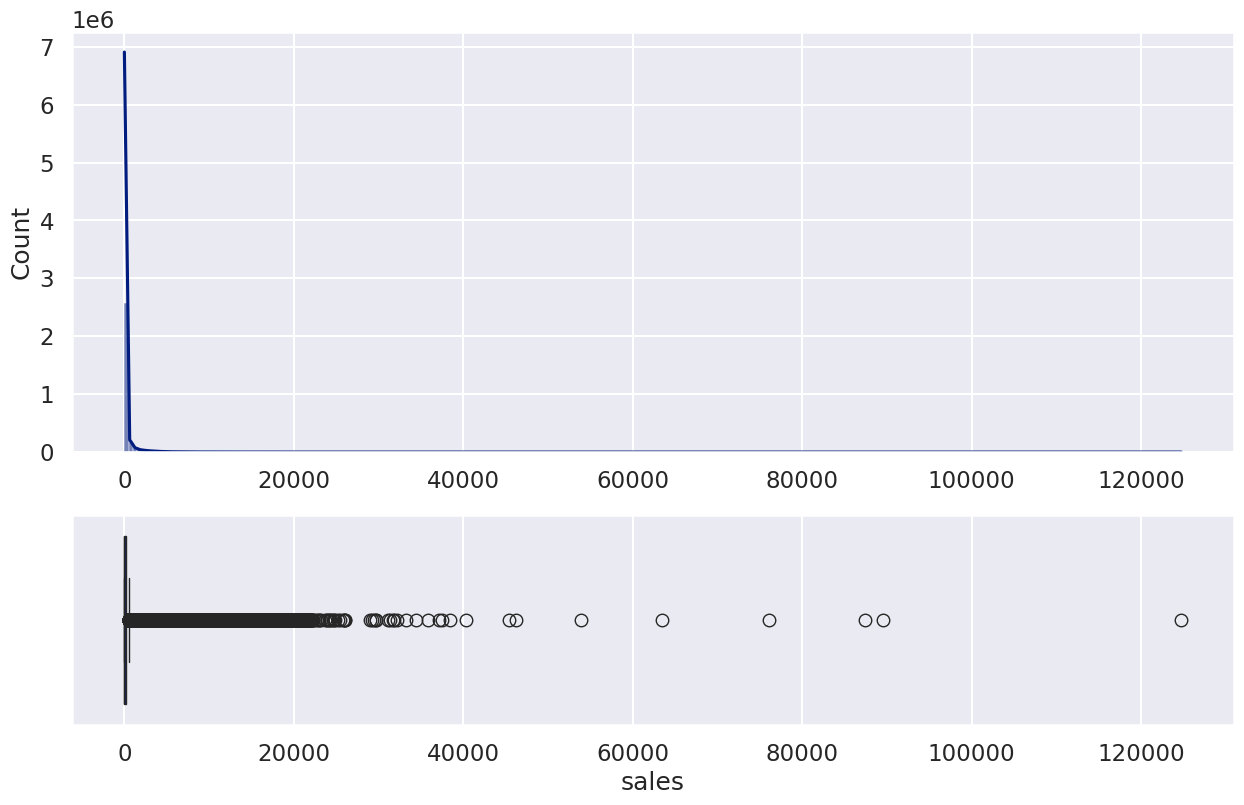

In [40]:
hist_box_plot(df[['sales']], 'sales', kde=True)

Since it is known that `sales` feature has a different unit system depending on the group of products (`family`)  
It might be better to consider a relative value. Let's divide `sales` by it's median value over each group of product  in days where anything was sold.

In [38]:
median_sales = df.query('sales > 0').groupby('family')['sales'].median().reset_index().rename(columns={'sales':'median_sales_over_family'})
df = df.merge(median_sales, on='family', how='left')
df['relative_sales'] = df['sales'] / df['median_sales_over_family']

df.drop(columns=['sales'], inplace=True)
num_cols.remove('sales')
num_cols.append('relative_sales')

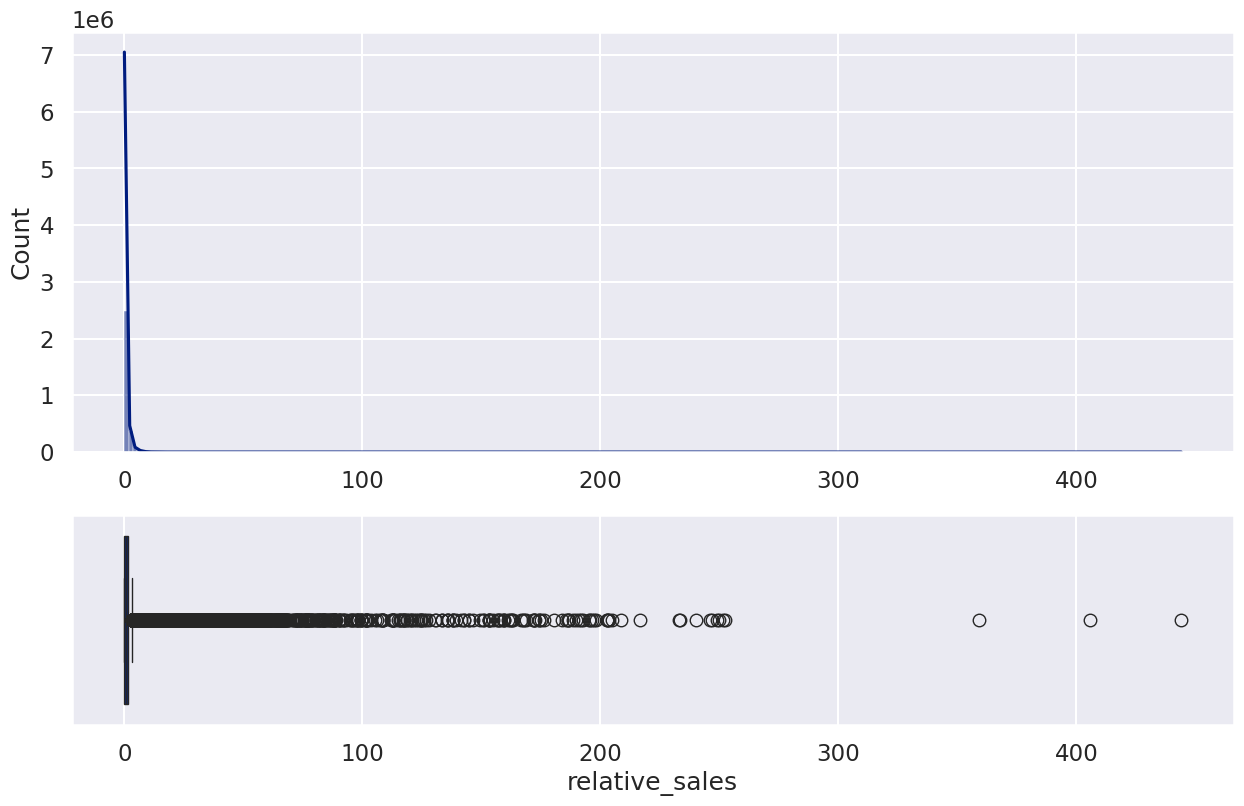

In [43]:
hist_box_plot(df[['relative_sales']], 'relative_sales', kde=True)

Let's apply IQR filter in order to remove too extreme sales values.  
Let `threshold` be equal to 10 instead of 1.5 so that not so many data is dropped

Clipped 17654 outliers, ratio - 0.58%


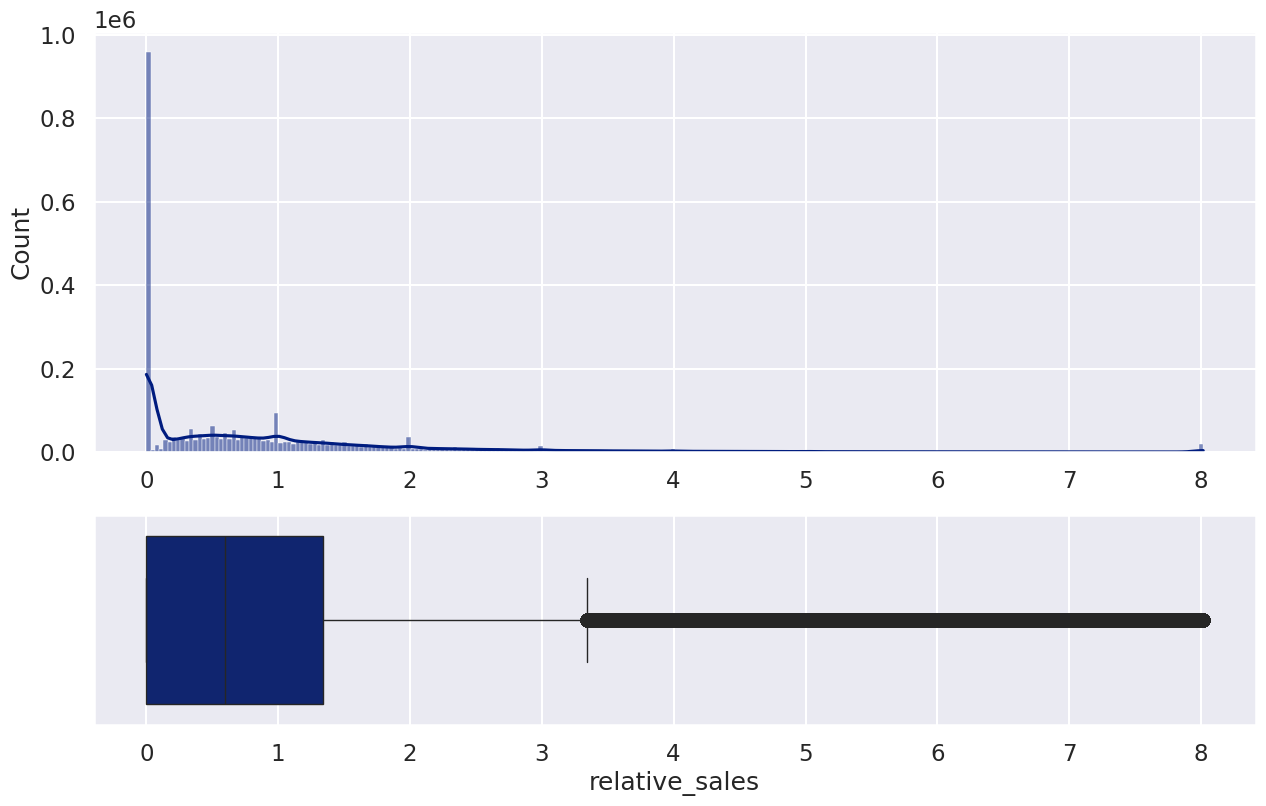

In [65]:
col = 'relative_sales'
iqr_feats[col] = 5
df2, _ = iqr_clipper(df.copy(), features={col: iqr_feats[col]}, is_submission_col='is_submission')
hist_box_plot(df2, col, kde=True)

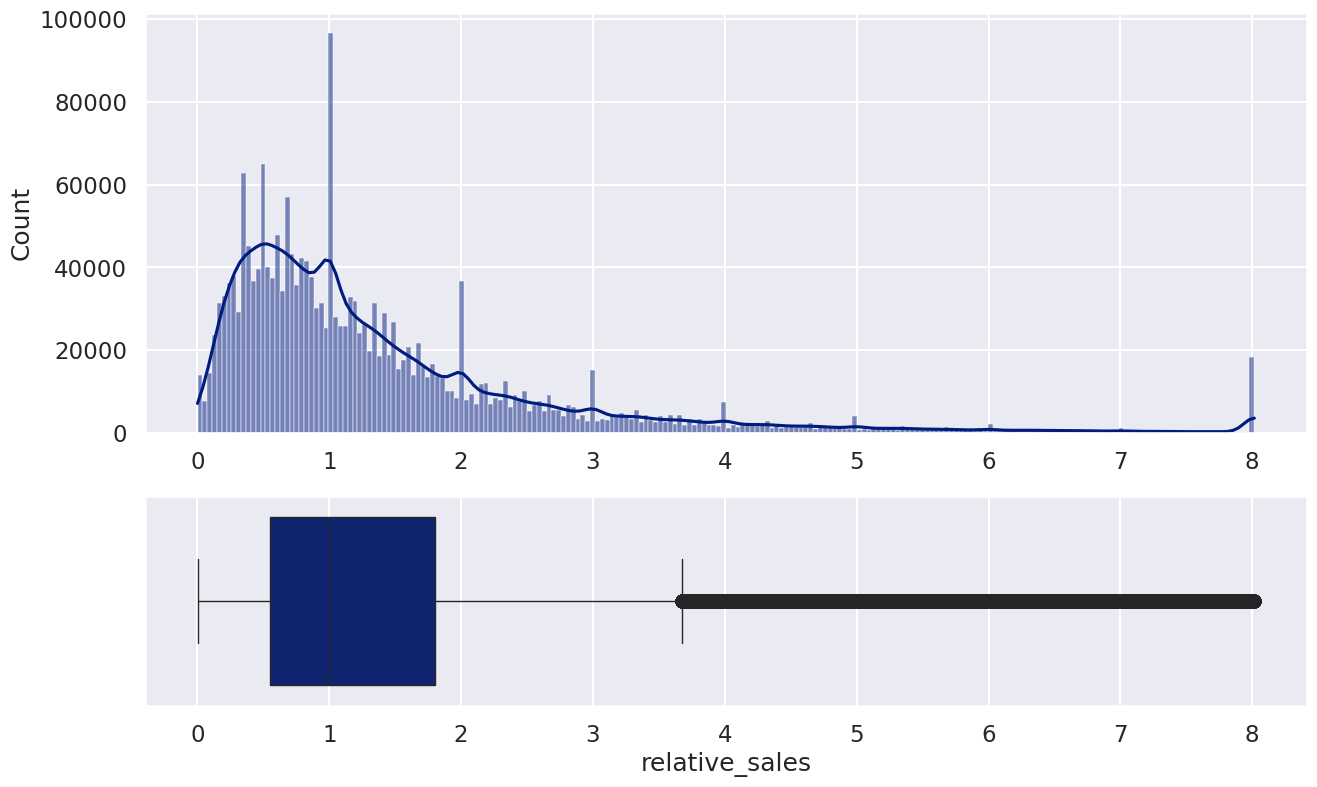

In [51]:
hist_box_plot(df2.query(f'{col} > 0'), col, kde=True)

It can be seen that there are a lot of zero values - days at which stores failed to sale any goods.  
If to omit them, a clear lognormal distribution can be observed

### 2. dcoilwtico

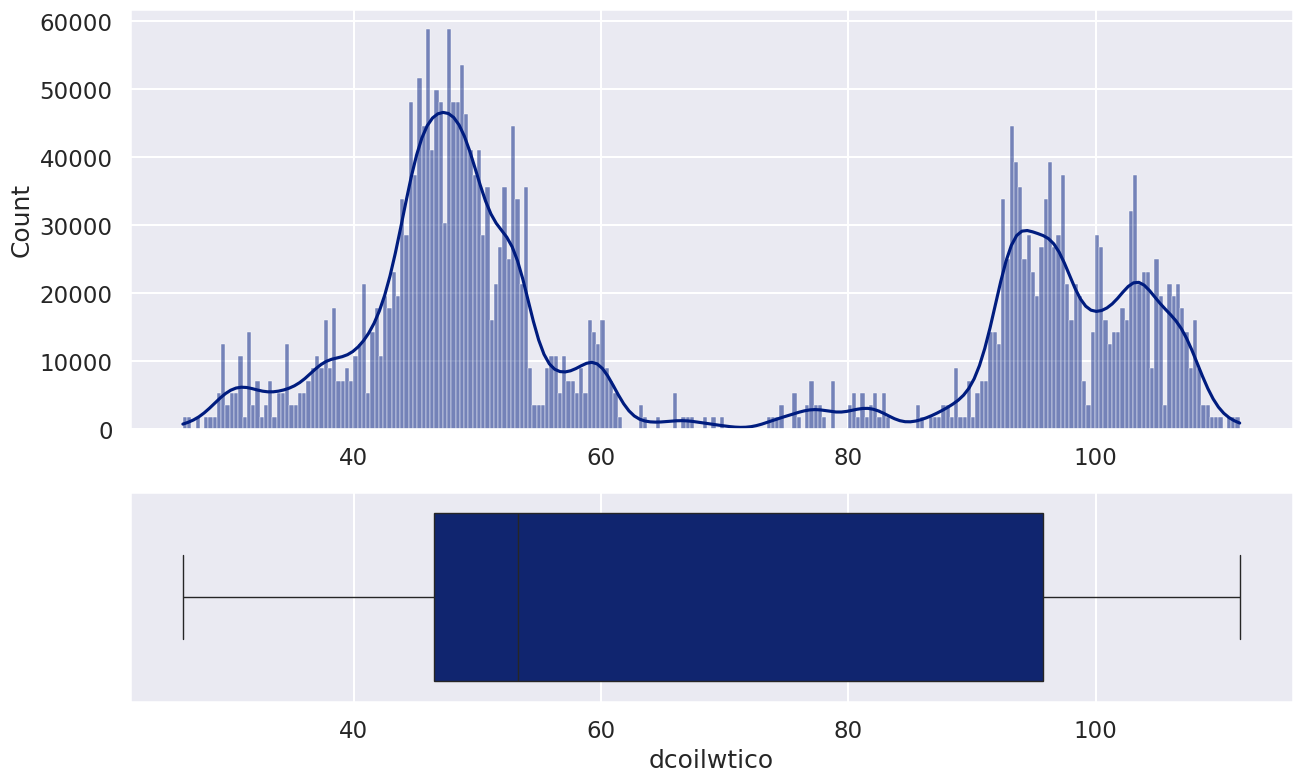

In [35]:
hist_box_plot(df[['dcoilwtico']], 'dcoilwtico', kde=True)

Although there are no outliers,  
it seems that this feature is sampled from two distributions with at least a different median value.  
If to analyse the time series plot earlier, it is clear that it is so due to a major decline in the  
price after 2015

### 3. transactions

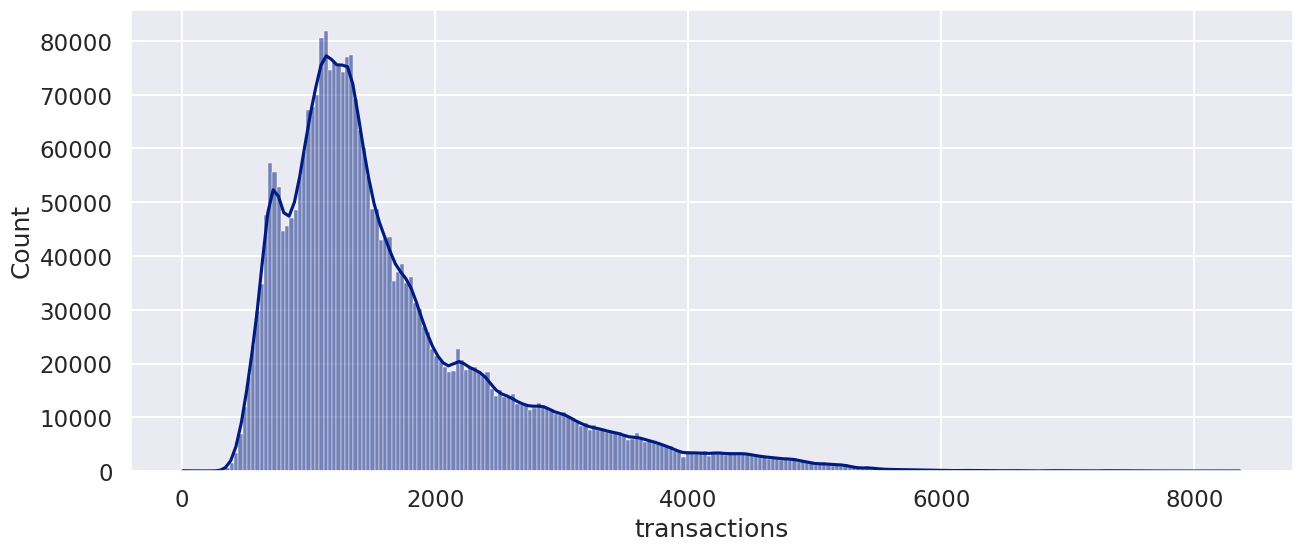

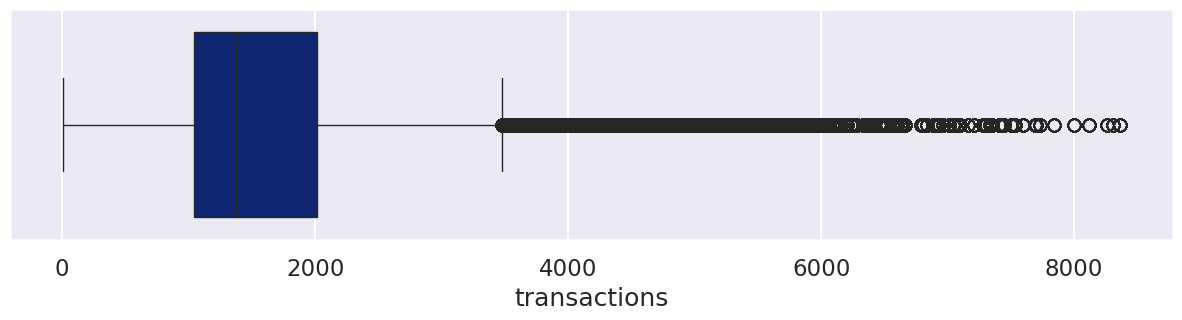

In [33]:
hist_box_plot(df[['transactions']], 'transactions', kde=True)

It seems like if to apply log1p transformtation, the distribution will lool like more normal.  
But let's leave it to the feature engineering part

Let's apply an IQR filter

Clipped 1353 outliers, ratio - 0.04%


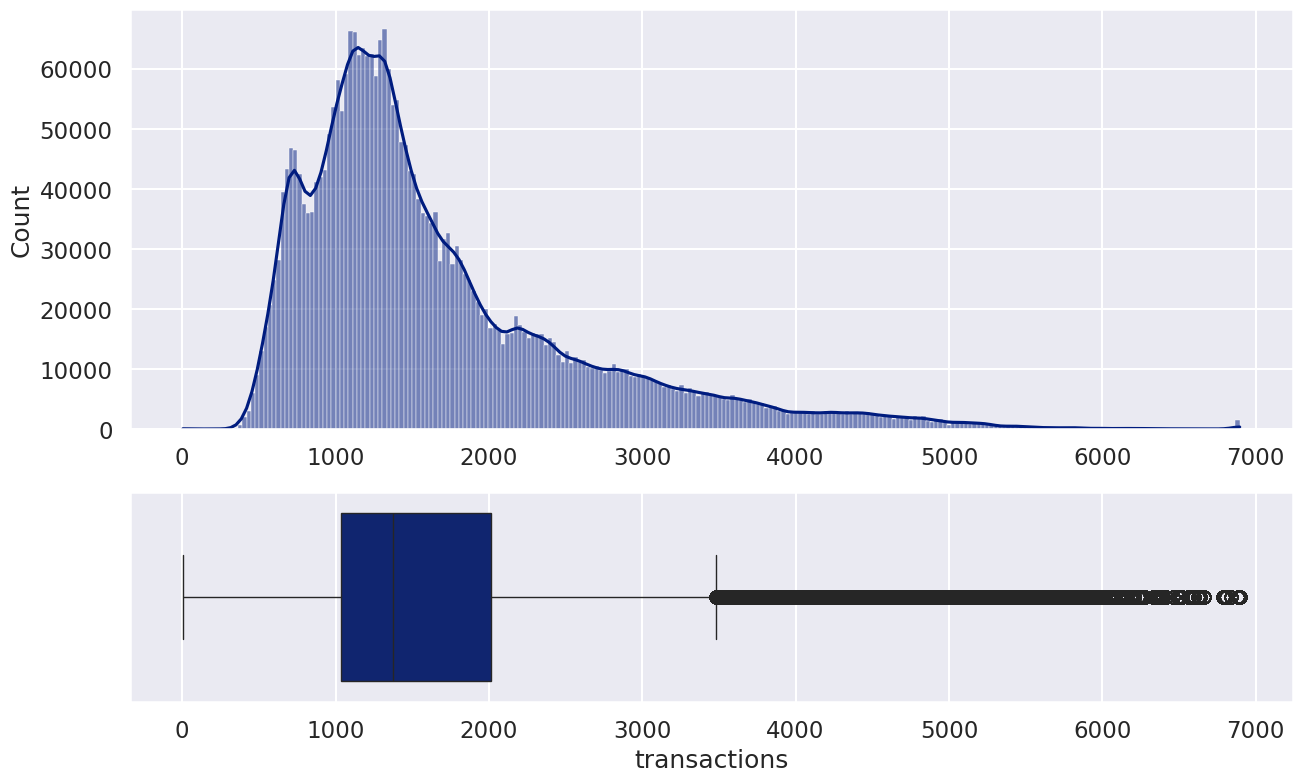

In [53]:
col = 'transactions'
iqr_feats[col] = 5
df2, _ = iqr_clipper(df.copy(), features={col: iqr_feats[col]}, is_submission_col='is_submission')
hist_box_plot(df2, col, kde=True)

### 4. onpromotion

In [54]:
df['onpromotion'].describe()

count    3.036528e+06
mean     2.638211e+00
std      1.227437e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.410000e+02
Name: onpromotion, dtype: float64

In [55]:
df['onpromotion'].value_counts().head(20)

onpromotion
0.0     2410848
1.0      178875
2.0       80488
3.0       46510
4.0       32051
5.0       24999
6.0       22570
7.0       19351
8.0       16055
9.0       14363
10.0      13097
11.0      11435
12.0      10105
13.0       8767
14.0       7490
15.0       6592
16.0       6090
17.0       5400
18.0       5047
19.0       4647
Name: count, dtype: int64

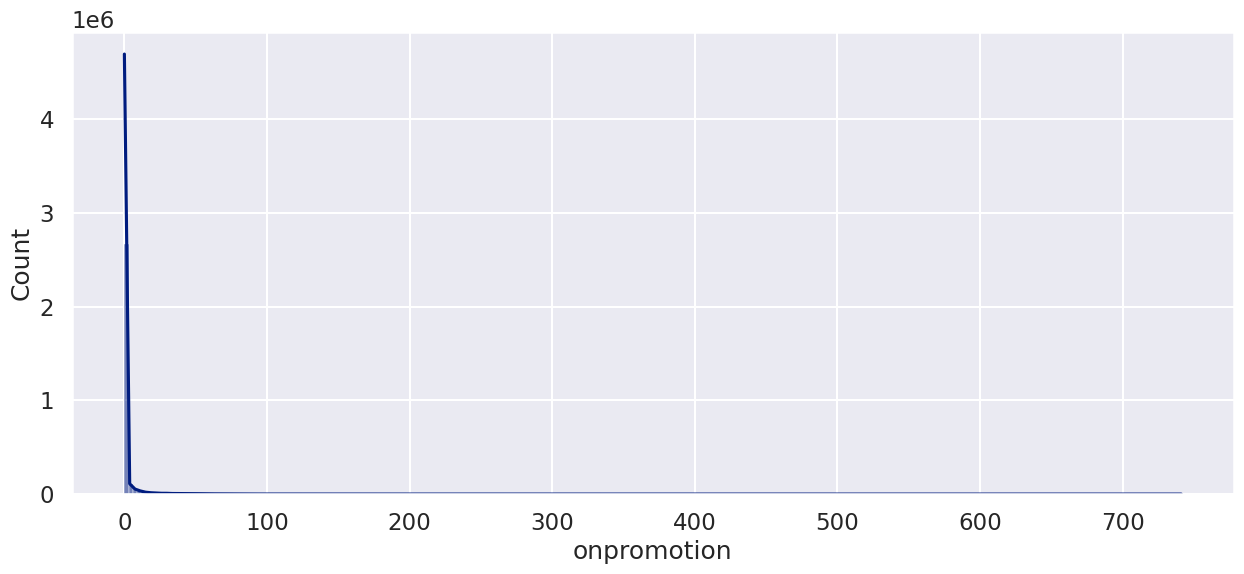

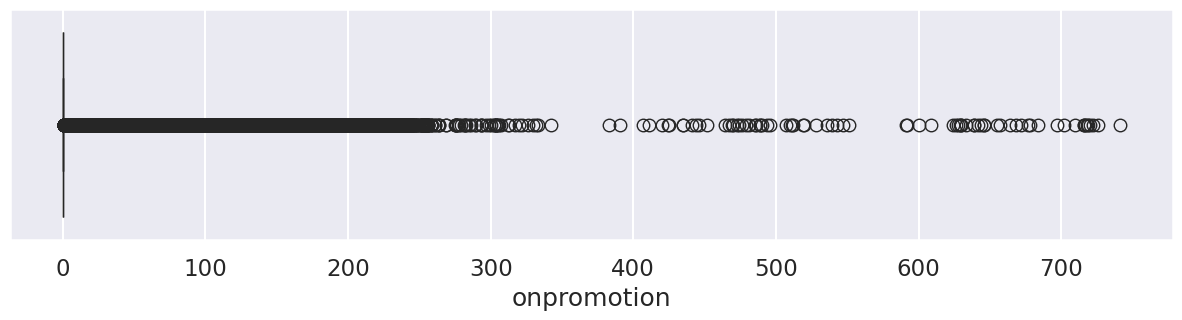

In [37]:
hist_box_plot(df[['onpromotion']], 'onpromotion', kde=True)

Removed 37191 outliers, ratio - 1.22%


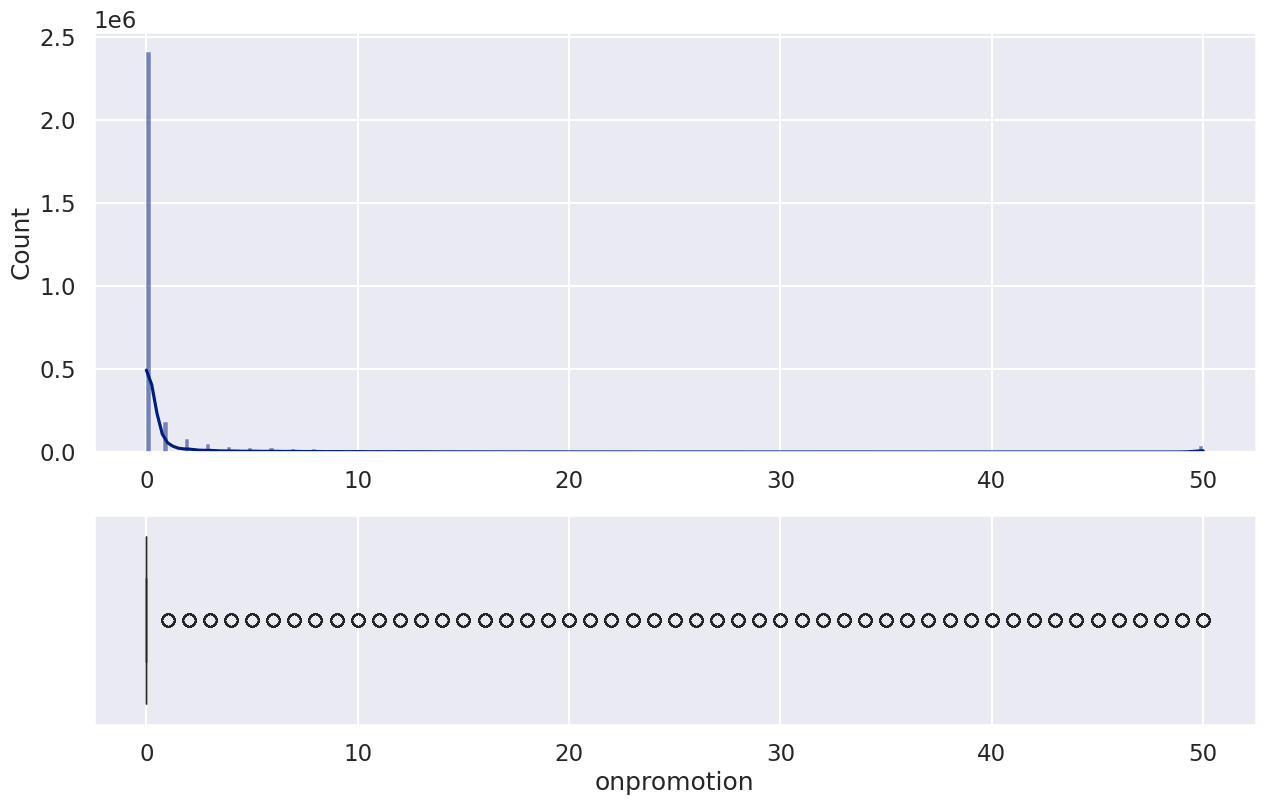

In [62]:
n_remained = (df['onpromotion'] <= 50).sum()
df2 = df[['onpromotion']].copy()

df2['onpromotion'] = df2['onpromotion'].clip(None , 50)
message(len(df), n_remained)

hist_box_plot(df2, 'onpromotion', kde=True)

## B. Categorical columns

### 1. city

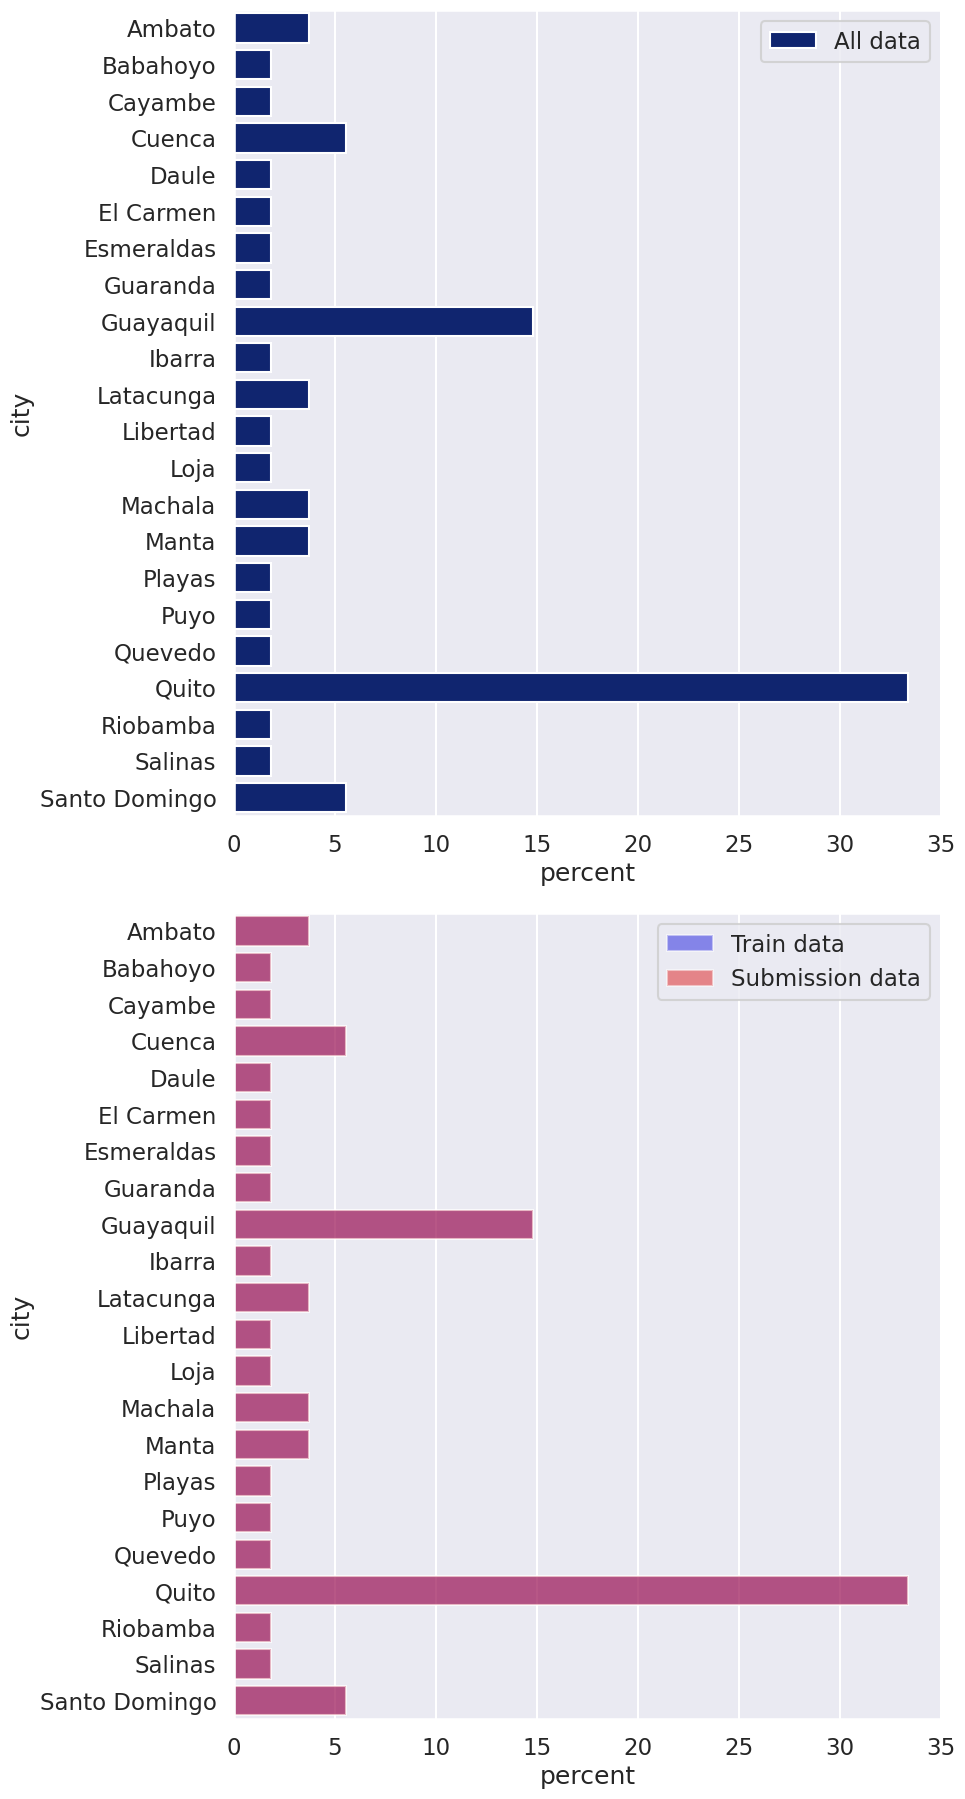

In [70]:
col = 'city'
train_submission_countplot(
    df=df[[col, 'is_submission']],
    col=col,
    is_submission_col='is_submission'
)

Though it is not a uniform distriution, there are no outliers.  
Moreover, the distribution is the same for both train and submission subsets

### 3. state

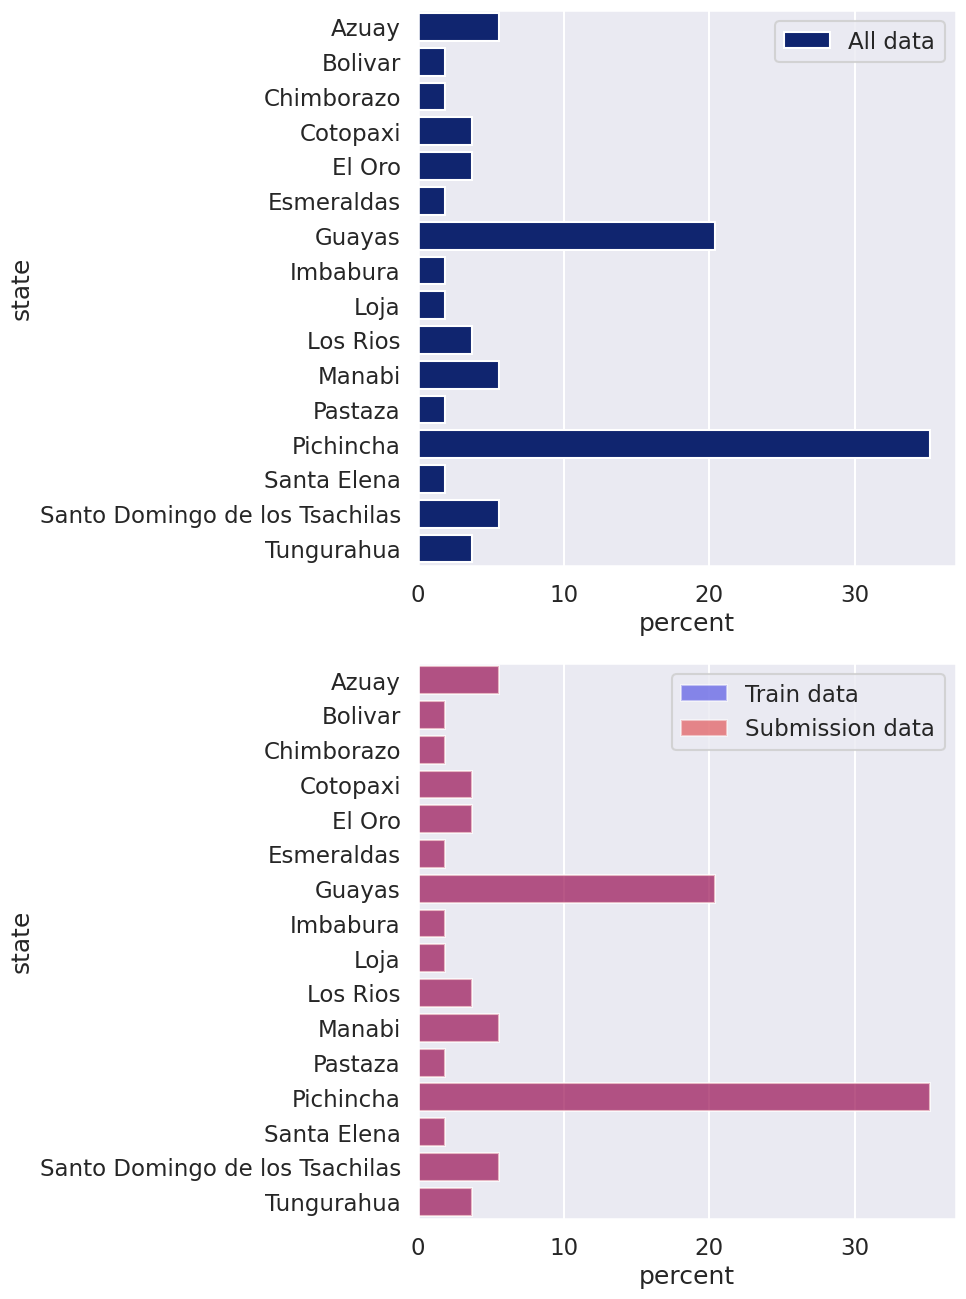

In [42]:
col = 'state'
train_submission_countplot(
    df=df[[col, 'is_submission']],
    col=col,
    is_submission_col='is_submission'
)

No outliers.  
The distribution is the same for both train and submission subsets

### 4. type

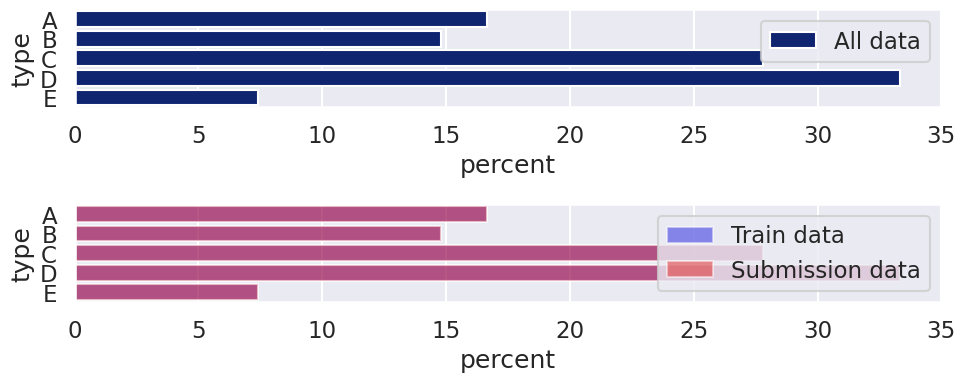

In [43]:
col = 'type'
train_submission_countplot(
    df=df[[col, 'is_submission']],
    col=col,
    is_submission_col='is_submission'
)

No outliers.  
The distribution is the same for both train and submission subsets

### 5. cluster

Text(0, 0.5, 'percent')

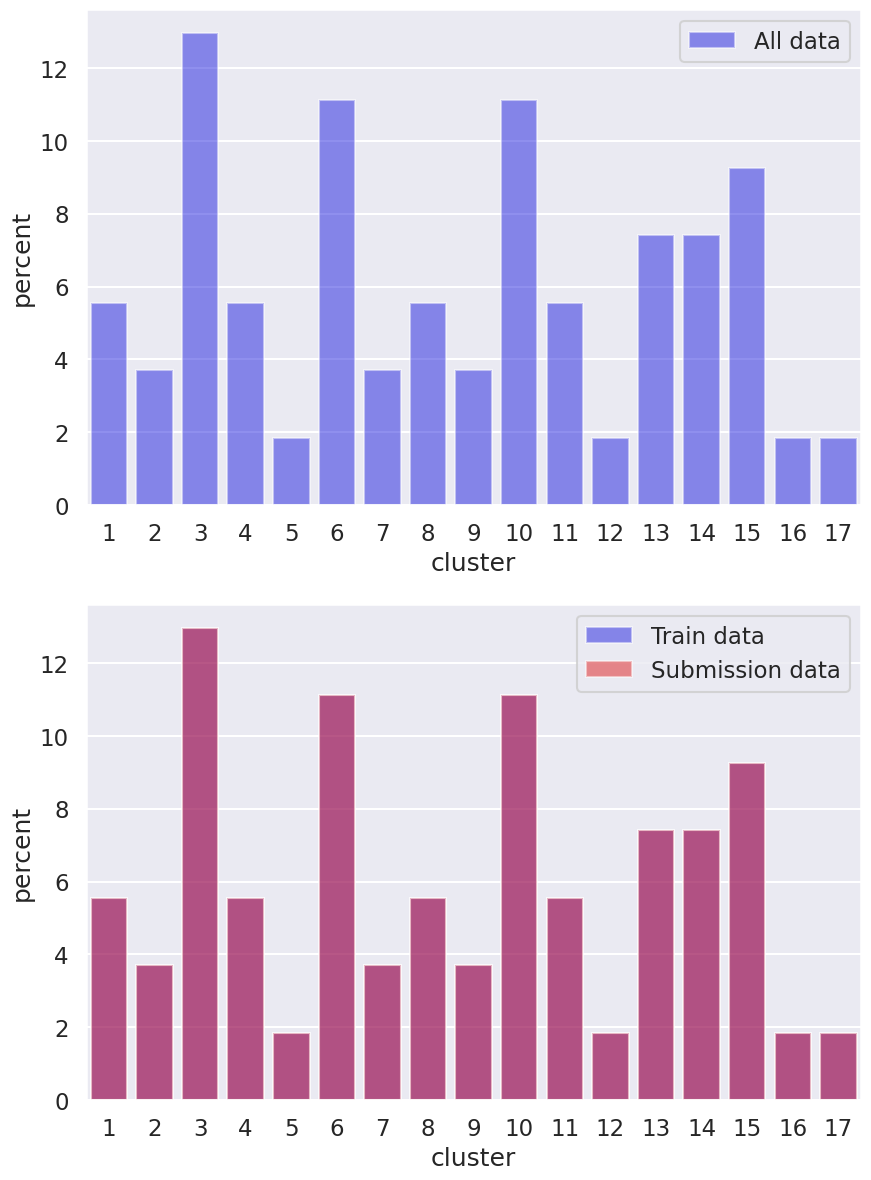

In [44]:
col = "cluster"
fig, ax = plt.subplots(2, 1, figsize=(10, 2 * 10 / 24 * df[col].nunique()))
sns.barplot(
    df[col].value_counts().sort_index()/len(df)*100,
    color="blue",
    alpha=0.5,
    ax=ax[0],
    label="All data",
)
ax[0].legend()
ax[0].set_ylabel('percent')
sns.barplot(
    df.query("not is_submission")[col].value_counts().sort_index()/len(df.query("not is_submission"))*100,
    color="blue",
    alpha=0.5,
    label="Train data",
    ax=ax[1],
)
sns.barplot(
    df.query("is_submission")[col].value_counts().sort_index()/len(df.query("is_submission"))*100,
    color="red",
    alpha=0.5,
    label="Submission data",
    ax=ax[1],
)
ax[1].legend()
ax[1].set_ylabel('percent')

No outliers.  
The distribution is the same for both train and submission subsets

## C. Applying all transformations

In [74]:
iqr_feats

{'relative_sales': 5, 'transactions': 5}

In [36]:
iqr_feats = {
    'relative_sales': 5,
    'transactions': 5
}

In [39]:
df2 = df.copy()

df2, mask = iqr_clipper(data=df2, features=iqr_feats, verbose=False, is_submission_col='is_submission')

mask &= (df2['onpromotion'] <= 50)

df2['onpromotion'] = df2['onpromotion'].clip(None, 50)


print(f"Number of observations: {len(df)}")
print(f"Number of observations not clipped: {sum(mask)}")
print(f"Ratio: {round(100*sum(mask)/len(df), 2)}%")
print(f"Number of outlier observations clipped: {len(df) - sum(mask)}")
print(f"Ratio: {round(100*(1 - sum(mask)/len(df)), 2)}%")

Number of observations: 3036528
Number of observations not clipped: 2981128
Ratio: 98.18%
Number of outlier observations clipped: 55400
Ratio: 1.82%


It can be seen that about 2 % of the data was identified as outliers,  
which is a good sign since not too much data was clipped.

## D. Multidimensional outliers (skipped)



So far, outliers have been considered per each features separately. However, it is possible to distinguish outliers  based on the combination of features.  
There are some methods to detect outliers in the high-dimensional space.  
Let's consider one of them - Isolation Forest.  
Since about 3.7% of the data has already been dropped, the contamination rate will be set to 0.013 (1.3 %)  


In [31]:
# num_cols.remove('sales')
# num_cols.append('relative_sales')

In [32]:
# from sklearn.preprocessing import LabelEncoder


# df3 = df2.copy()

# label_encoder = LabelEncoder()
# for col in cat_cols:
#     df3[col] = label_encoder.fit_transform(df3[col])

# model = IsolationForest(contamination=0.013, random_state=42)
# is_outlier = model.fit_predict(df3.query('is_submission == False')[num_cols + cat_cols])

# df3 = df2.copy()
# df3['outlier'] = 1
# df3.loc[~df3['is_submission'], 'outlier'] = is_outlier
# df3 = df3.query('outlier == 1').drop(columns=['outlier'])

# print(f"Number of observations before dropping outliers: {len(df)}")
# print(f"Number of observations after dropping outliers: {len(df3)}")
# print(f"Ratio: {round(100*len(df3)/len(df), 2)}%")
# print(f"Number of outlier observations dropped: {len(df) - len(df3)}")
# print(f"Ratio: {round(100*(1 - len(df3)/len(df)), 2)}%")

Number of observations before dropping outliers: 3029400
Number of observations after dropping outliers: 2880694
Ratio: 95.09%
Number of outlier observations dropped: 148706
Ratio: 4.91%


# VI. Train test splitting

Let's split the data into train and test.  

Let's use the data at the last 3 month as the test subset

In [40]:
mask = df['date'] > df.query('not is_submission')['date'].max() - pd.Timedelta(days=92)

df2['subset'] = 'train'
df2['subset'].loc[mask] = 'test'
df2['subset'].loc[df2['is_submission']] ='submission'

df2['subset'].value_counts()

subset
train         2844072
test           163944
submission      28512
Name: count, dtype: int64

In [41]:
df2.query("subset == 'train'")['relative_sales'].describe()

count    2.844072e+06
mean     9.670166e-01
std      1.324263e+00
min      0.000000e+00
25%      0.000000e+00
50%      5.682057e-01
75%      1.326050e+00
max      8.016048e+00
Name: relative_sales, dtype: float64

In [42]:
df2.query("subset == 'test'")['relative_sales'].describe()

count    163944.000000
mean          1.362866
std           1.458434
min           0.000000
25%           0.415323
50%           1.000000
75%           1.793758
max           8.016048
Name: relative_sales, dtype: float64

The statistics are almost the same for both subsets

Let's check the distributions

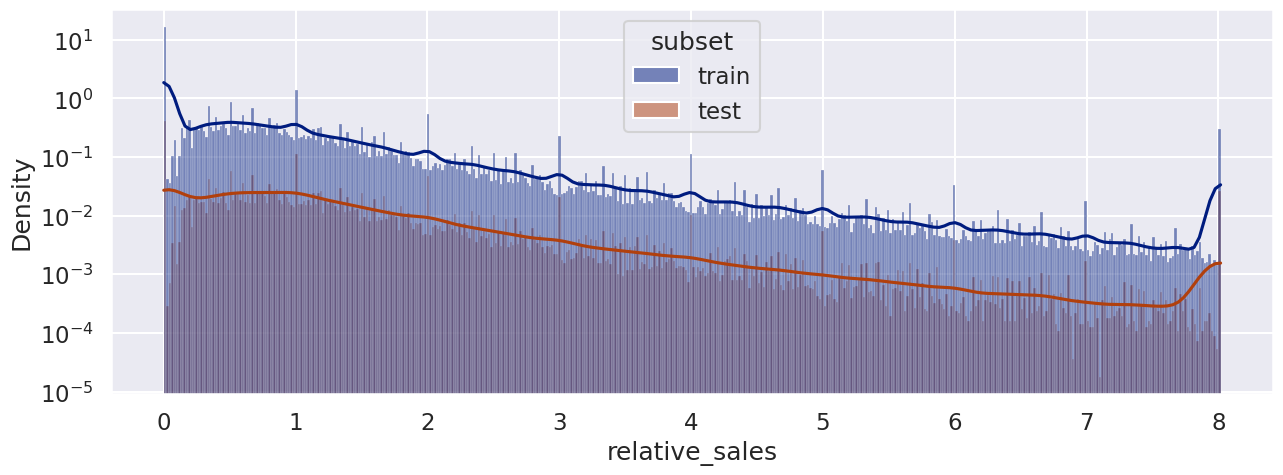

In [122]:
x = 'relative_sales'

fig, axs = plt.subplots(1, figsize=(15, 5))
sns.histplot(data=df2.query("subset != 'submission'"), x=x, kde=True, stat='density', ax=axs, hue='subset', alpha=0.5)
axs.set_yscale('log')

plt.show()

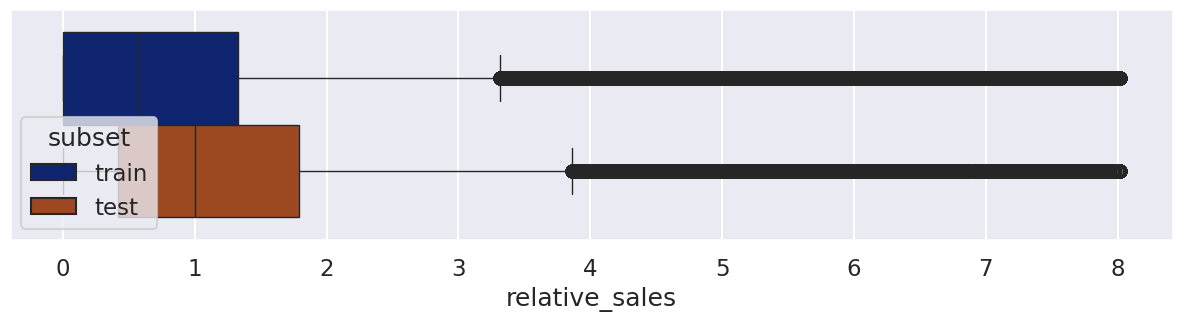

In [123]:
fig, axs = plt.subplots(1, figsize=(15, 3))

sns.boxplot(data=df2.query("subset != 'submission'"), x=x, orient="h", ax=axs, hue='subset')
plt.show()


In [130]:
compare_disributions(data=df2, subsets=['train', 'test'], feature=x)

  0%|          | 0/1 [00:00<?, ?it/s]

,subset1,subset2,ks_2samp.pvalue,anderson_ksamp.pvalue,significance_level,ks_2samp.are_similar,anderson_ksamp.are_similar
0,train,test,0.0,0.001,0.05,False,False


The distribution looks the similar according to the histplot, though it is not exactly so according to the statistical tests

# VII. Saving data

In [43]:
df2.isnull().sum()

id                              0
date                            0
store_nbr                       0
family                          0
onpromotion                     0
is_submission                   0
city                            0
state                           0
type                            0
cluster                         0
dcoilwtico                      0
transactions                    0
median_sales_over_family        0
relative_sales              28512
subset                          0
dtype: int64

In [44]:
df2.set_index('id').to_csv('../data/artifacts/cleaned_data.csv', chunksize=100000)